In [26]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import seed
from tensorflow import set_random_seed
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers







In [2]:
seed(10)
set_random_seed(10)

In [3]:
data_dir = 'C:/Users/sbava/OneDrive/Documents/Sensor_DataSet'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

In [4]:
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('Averaged_BearingTest_Dataset.csv')
print("Dataset shape:", merged_data.shape)
merged_data.head()

Dataset shape: (190, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 12:32:39,0.061090,0.074832,0.080787,0.043524
2004-02-12 12:42:39,0.062599,0.075488,0.080626,0.044679
2004-02-12 12:52:39,0.062341,0.075601,0.080398,0.044246
2004-02-12 14:22:39,0.062607,0.076501,0.081133,0.045041
2004-02-12 14:52:39,0.061452,0.076662,0.080872,0.043867


In [5]:
train = merged_data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test = merged_data['2004-02-15 12:52:39':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)



Training dataset shape: (83, 4)
Test dataset shape: (107, 4)


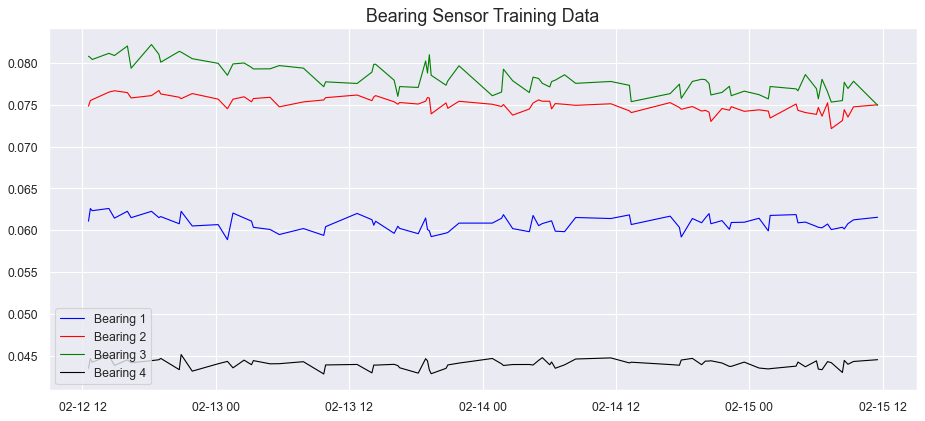

In [6]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()



In [8]:
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

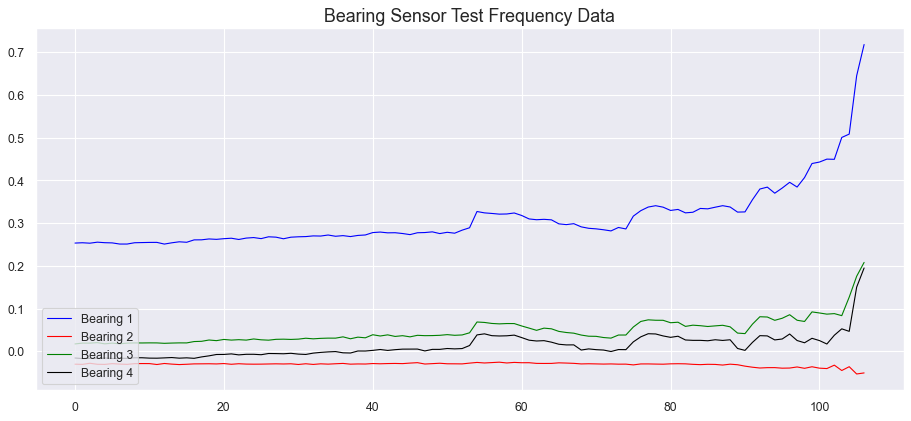

In [9]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

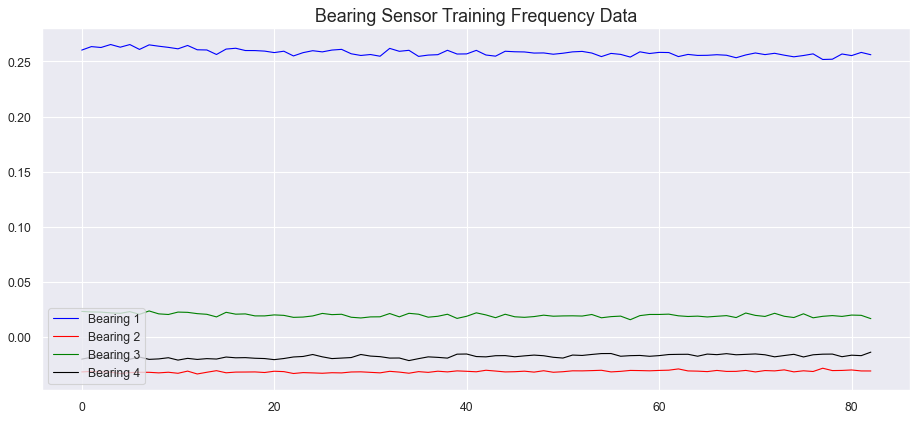

In [10]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()




In [11]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)



['scaler_data']

In [12]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)



Training data shape: (83, 1, 4)
Test data shape: (107, 1, 4)


In [13]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model



In [14]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 4)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 4)              68  

In [15]:
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history



Train on 78 samples, validate on 5 samples
Epoch 1/100
78/78 [==============================] - 1s 17ms/step - loss: 0.5333 - val_loss: 0.4216
Epoch 2/100
78/78 [==============================] - 0s 235us/step - loss: 0.5243 - val_loss: 0.4132
Epoch 3/100
78/78 [==============================] - 0s 355us/step - loss: 0.5152 - val_loss: 0.4045
Epoch 4/100
78/78 [==============================] - 0s 410us/step - loss: 0.5058 - val_loss: 0.3956
Epoch 5/100
78/78 [==============================] - 0s 308us/step - loss: 0.4961 - val_loss: 0.3862
Epoch 6/100
78/78 [==============================] - 0s 308us/step - loss: 0.4858 - val_loss: 0.3761
Epoch 7/100
78/78 [==============================] - 0s 308us/step - loss: 0.4749 - val_loss: 0.3663
Epoch 8/100
78/78 [==============================] - 0s 465us/step - loss: 0.4634 - val_loss: 0.3567
Epoch 9/100
78/78 [==============================] - 0s 351us/step - loss: 0.4514 - val_loss: 0.3476
Epoch 10/100
78/78 [=============================

Epoch 81/100
78/78 [==============================] - 0s 308us/step - loss: 0.1255 - val_loss: 0.1471
Epoch 82/100
78/78 [==============================] - 0s 308us/step - loss: 0.1256 - val_loss: 0.1474
Epoch 83/100
78/78 [==============================] - 0s 308us/step - loss: 0.1254 - val_loss: 0.1467
Epoch 84/100
78/78 [==============================] - 0s 308us/step - loss: 0.1253 - val_loss: 0.1466
Epoch 85/100
78/78 [==============================] - 0s 315us/step - loss: 0.1257 - val_loss: 0.1461
Epoch 86/100
78/78 [==============================] - 0s 418us/step - loss: 0.1257 - val_loss: 0.1463
Epoch 87/100
78/78 [==============================] - 0s 308us/step - loss: 0.1251 - val_loss: 0.1462
Epoch 88/100
78/78 [==============================] - 0s 355us/step - loss: 0.1254 - val_loss: 0.1462
Epoch 89/100
78/78 [==============================] - 0s 308us/step - loss: 0.1250 - val_loss: 0.1466
Epoch 90/100
78/78 [==============================] - 0s 308us/step - loss: 0.1249

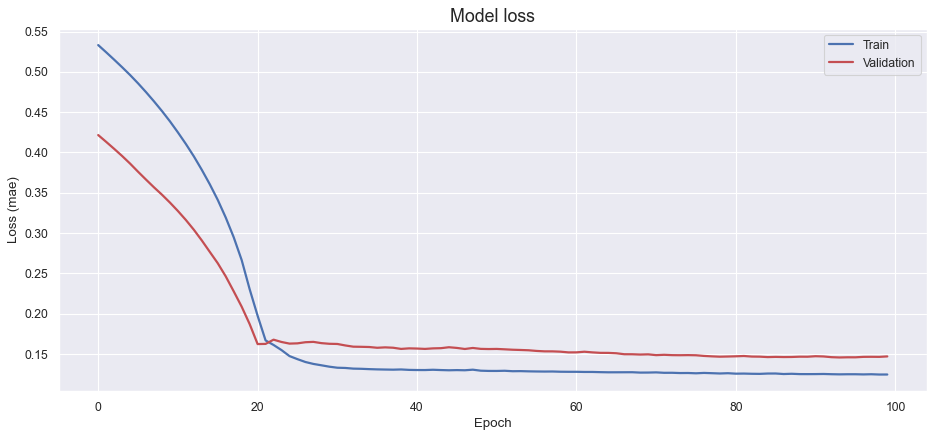

In [16]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()



C:\Users\sbava\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

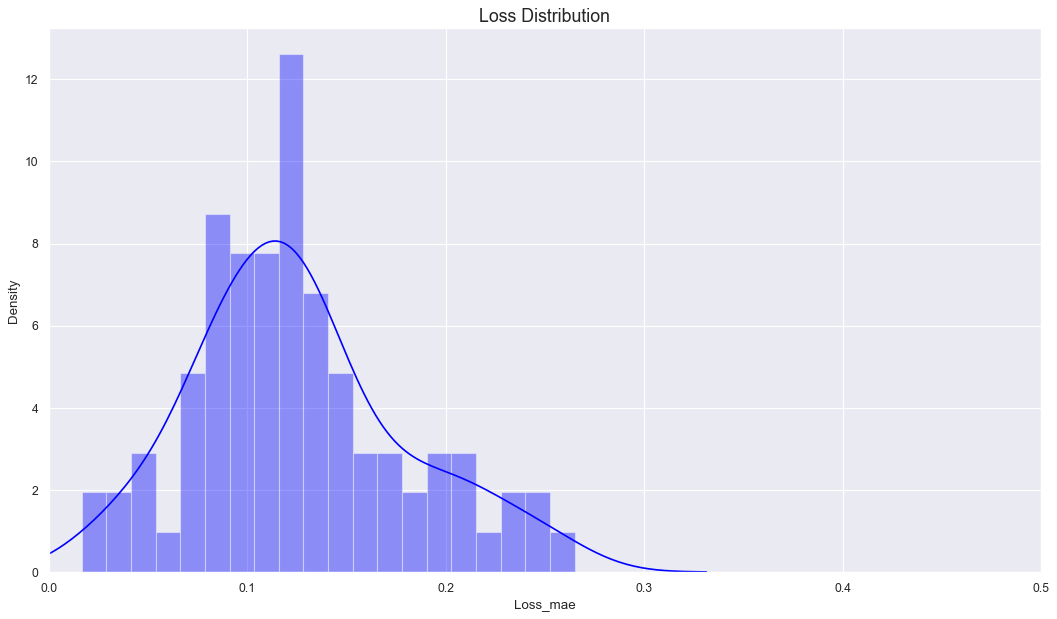

In [18]:


X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])




In [19]:
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()



,Loss_mae,Threshold,Anomaly
2004-02-15 13:12:39,0.121100,0.275,False
2004-02-15 13:22:39,0.083080,0.275,False
2004-02-15 17:22:39,0.227496,0.275,False
2004-02-15 17:52:39,0.072212,0.275,False
2004-02-15 18:52:39,0.070776,0.275,False


In [21]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])




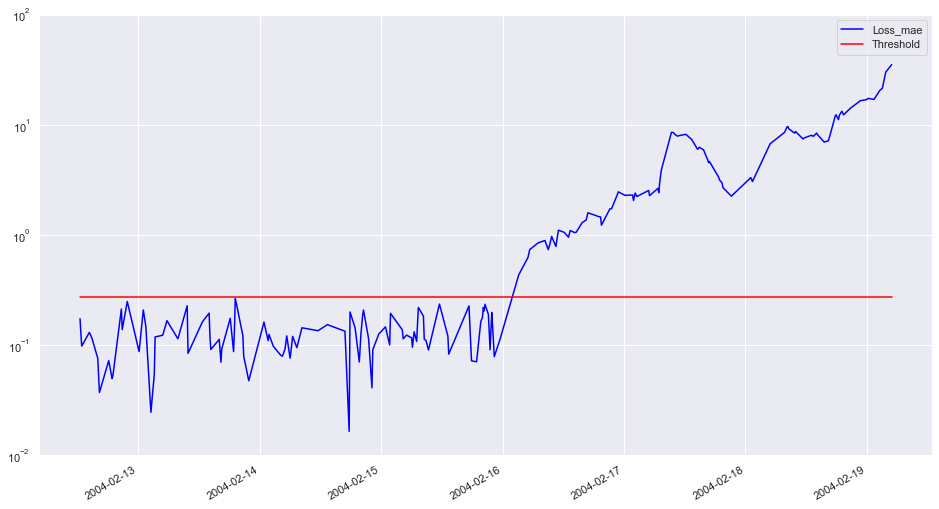

In [22]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])



In [23]:
model.save("Cloud_model.h5")
print("Model saved")

Model saved
